This notebook contains the project for Complex system simulation, Complex financial networks

In [655]:
# imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import sys
import os
import time
import datetime
import pickle
import argparse
import itertools
from typing import List, Tuple
import doctest
import pandas as pd
import powerlaw


# Financial contract network

Agent (nodes) want to enter into contracts with other agents (Links) to reduce their risk exposure. We will simulate what happens over time, studying when a total system collapse becomes more likely to occur as a function of the size of perturbation to the system.

1. There are total of $N$ Agents (nodes) and the i'th agent will have an exposure $e_i$ which initialized as a random number between 1 and -1.

2. Agents try to minimize their exposure by forming a link to another agent with opposite expsure, meaning finding another node with the opposite sign of $e_i$, namely $e_j$ such that the sum of their exposures $\Sigma e$ is as close to 0 as possible. A link is formed if $\Sigma e$ is minimal, if $\Sigma e$ is above a threshold, $T_e$, such that $\Sigma e$ > $T_e$ no link will be formed. 

We have to options for the link weights- Option B: The link weight is equal to the previous exposure of the node, and links are always biirectional but carry different weights. Thus the link weights become: $W$ is a weight function, so that $W(L_{ij}) = e_{ij}$ and $W(L_{ji}) = e_{ji}$ 

3. Each timestep the exposure of an agent is a brownian motion. Agents have exposure to the price of stock. We assume all agents have exposure to the same asset for simplicity. 

Agents have total volatility $V$, which is $e$ times the prive movement $S$, $e * S = V$. If V $<$ or $>$ threshold value $T_v$, an agent becomes bankrupt and also dies (meaning the node gets removed). This causes all links $L_{ij}$ to be removed and the values of the weights $W_{L_{ij}}$ to be added $e_{j}$ which is the exposure of $N_{j}$, which then increases the chances of $e_{j} > T_e$ and $N_{j}$ dying as a result, causing the effect to propagate.

- Hypothesis is that an increased average move away from the mean causes a higher probability of default when the number of links is higher



Limitations: 
- Bank only link at most twice, which is unrealistic as banks have more transactions
- There is only 1 asset

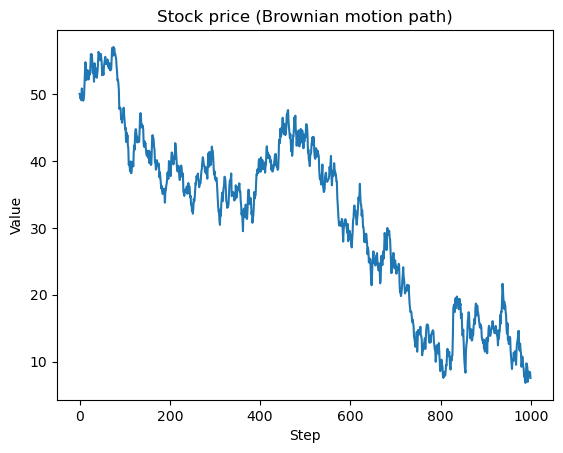

In [ ]:
def brownian_motion(num_steps, delta_t, sigma):
    """
    Generate a Brownian motion path.

    Parameters:
    num_steps (int): Number of steps in the Brownian motion.
    delta_t (float): Time increment.
    sigma (float): Standard deviation of the increments (sqrt of variance).

    Returns:
    np.array: A numpy array representing the Brownian motion path.
    """
    # Generate random increments from a normal distribution
    increments = np.random.normal(0, sigma * np.sqrt(delta_t), num_steps-1)

    # The start point is typically zero
    start_point = 0

    # Compute the Brownian motion path
    return np.cumsum(np.insert(increments, 0, start_point)) +50

# Testing
num_steps = 1000
delta_t = 0.01
sigma = 10

brownian_path = brownian_motion(num_steps, delta_t, sigma)

plt.plot(brownian_path)
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Stock price (Brownian motion path)')
plt.show()


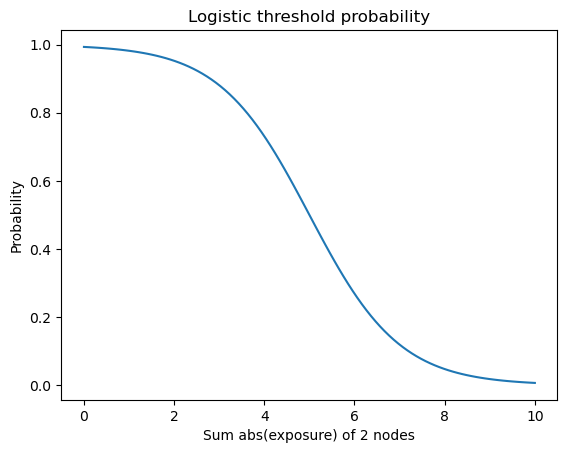

In [ ]:
# logistic threshold probability

def logistic_threshold_probability(x, a, b, threshold):
    """
    Compute the logistic threshold probability.

    Parameters:
    x (float): The value at which to compute the probability.
    a (float): The logistic growth rate.
    b (float): The logistic threshold.

    Returns:
    float: The logistic threshold probability.
    """
    scaling = 10/threshold

    return 1 - 1 / (1 + np.exp(-a * (x - b)))


threshold = 5


xs = np.linspace(0, 10, 100)
ys = logistic_threshold_probability(xs, 1, 5, threshold)

plt.plot(xs, ys)
plt.xlabel('Sum abs(exposure) of 2 nodes')
plt.ylabel('Probability')
plt.title('Logistic threshold probability')
plt.show()


In [ ]:
def sum_absolute_edge_weights(graph):
    """
    Sums the absolute values of the edge weights in a NetworkX graph.

    :param graph: A NetworkX graph with weighted edges.
    :return: The sum of the absolute values of the edge weights.
    """
    # Initialize the sum to zero
    total_weight = 0

    # Iterate over all edges in the graph
    for (u, v, weight) in graph.edges(data='weight'):
        # Sum the absolute values of the edge weights
        total_weight += abs(weight)

    return total_weight

In [ ]:
def simulate_brownian_motion_one_step(exposures, delta_t, sigma):
    """
    Simulate Brownian motion for each agent's exposure for one step.

    Parameters:
    exposures (np.array): Initial exposures of the agents.
    delta_t (float): Time increment.
    sigma (float): Standard deviation of the increment.

    Returns:
    np.array: Updated exposures after one step of Brownian motion simulation.
    """
    # Generate random increments from a normal distribution for one step
    increments = np.random.normal(0, sigma * np.sqrt(delta_t), len(exposures))

    # Update exposures with the increments
    updated_exposures = exposures + increments
    return updated_exposures

In [ ]:
def generate_exposures(N, mu=0, sigma=0):
    """
    Generate a random set of exposures for N agents.

    Parameters:
    N (int): Number of agents.

    Returns:
    np.array: A numpy array representing the exposures of the agents.
    """
    return np.random.uniform(-1, 1, N)

In [ ]:
def create_directional_graph(N_Nodes, edges=None):
    """
    Creates a directed graph using NetworkX and initializes 'exposure' attribute for each node.

    Parameters:
    N_Nodes (int): The number of nodes in the graph.
    edges (list of tuples, optional): A list of edges to add to the graph.

    Returns:
    nx.DiGraph: A NetworkX directed graph with initialized 'exposure' attribute for each node.
    """
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(range(N_Nodes))

    # Initialize 'exposure' for each node
    exposures = generate_exposures(N_Nodes)
    for node, exposure in zip(G.nodes(), exposures):
        G.nodes[node]['exposure'] = exposure


    # Initialize 'connected_this_timestep' flag for each node
    exposures = generate_exposures(N_Nodes)
    for node, exposure in zip(G.nodes(), exposures):
        G.nodes[node]['connected_this_timestep'] = False

    # Add edges if provided
    if edges is not None:
        for edge in edges:
            G.add_edge(*edge)  # Unpack the tuple for adding an edge

    return G

Agents are willing to link if their summed exposure is small, because then it brings their new exposure closer to 0. The new exposure $E_{i_{t+1}}$ is a random draw between -1 and 1.

If a node cannot find any other node to link with (Due to threshold or or because there are simply no nodes to link with) 

then becomes $E_{i_{t}}$ + the column and row sums of the adjacency matrix. 

In [ ]:
# # Previous version Nitai, probably remove later but keep now for backup

# def form_links_and_update_exposures(G: nx.DiGraph, linking_threshold: float) -> nx.DiGraph:
#     """
#     Forms links between nodes in a graph based on exposure values and a linking threshold, 
#     and updates the exposures of these nodes.

#     Parameters:
#     G (nx.DiGraph): The graph to which the nodes belong.
#     linking_threshold (float): The threshold below which the absolute sum of exposures will trigger a link.

#     Returns:
#     nx.DiGraph: The updated graph with new links and updated exposures.
#     """
#     for i in G.nodes:
#             closest_sum = np.inf
#             closest_node = None

#             if not G.nodes[i]['connected_this_timestep']:
#                 for j in G.nodes:
#                     if not G.nodes[j]['connected_this_timestep'] and i != j:
#                         sum_of_exposures = G.nodes[i]['exposure'] + G.nodes[j]['exposure']

#                         if (np.abs(sum_of_exposures) < np.abs(closest_sum)) and (np.abs(sum_of_exposures) < linking_threshold):
#                             closest_sum = sum_of_exposures
#                             closest_node = j

#                 if closest_node is not None:
#                     # Edge creation and exposure update
#                     G.add_edge(i, closest_node, weight=G.nodes[i]['exposure'])
#                     G.add_edge(closest_node, i, weight=G.nodes[closest_node]['exposure'])
#                     G.nodes[i]['exposure'] += G.nodes[closest_node]['exposure']
#                     G.nodes[closest_node]['exposure'] += G.nodes[i]['exposure']

#                     # Setting the connection flag for both nodes
#                     G.nodes[i]['connected_this_timestep'] = True
#                     G.nodes[closest_node]['connected_this_timestep'] = True

#         # Resetting the flag for the next timestep
#     for node in G.nodes:
#         G.nodes[node]['connected_this_timestep'] = False

#     return G

In [695]:
# Version Sun, using her linking logic

def form_links_and_update_exposures(G: nx.DiGraph, linking_threshold: float, mode = 'devide exposure Singly') -> nx.DiGraph:
    """
    This function forms links between nodes in a directed graph based on the nodes' exposure values and a specified linking threshold.
    It also updates the exposure values of these nodes according to the linking mode.

    In 'devide exposure equally' mode, the sum of the exposures of both nodes involved in a link is evenly distributed to each node.
    This means that after linking, each node will have an exposure value equal to the average of their previous exposures.
    The weight of the link created is based on the change in exposure of the nodes as a result of this process.

    In 'devide exposure singly' mode, one node's exposure is set to zero and the other node receives the entire sum of both exposures.
    This mode is not detailed in the docstring as it is less frequently used.

    Parameters:
    G (nx.DiGraph): The graph to which the nodes belong. Each node should have an 'exposure' and a 'connected_this_timestep' attribute.
    linking_threshold (float): The threshold below which the absolute sum of exposures will trigger a link formation.
    mode (str): The mode of exposure division. Defaults to 'devide exposure equally'.

    Returns:
    nx.DiGraph: The updated graph with new links and updated exposures.
    """

    if linking_threshold == 0:
        linking_threshold = sys.float_info.epsilon



    for i in G.nodes:
        closest_sum = np.inf
        closest_node = None

        if not G.nodes[i]['connected_this_timestep']:
            for j in G.nodes:
                if not G.nodes[j]['connected_this_timestep'] and i != j and G.nodes[i]['exposure'] * G.nodes[j]['exposure'] < 0:
                    sum_of_exposures = G.nodes[i]['exposure'] + G.nodes[j]['exposure']

                    if (np.abs(sum_of_exposures) < np.abs(closest_sum)) and ((np.abs(sum_of_exposures) < linking_threshold)):
                        closest_sum = sum_of_exposures
                        closest_node = j

        if closest_node:

            # deviding the exposure singly means one node gets 0 exposure and the other node gets the remaining exposure
            if mode == 'devide exposure singly':

                # Calculate hedge value based on the smaller absolute exposure of the two nodes
                hedge_value = min(abs(G.nodes[i]['exposure']), abs(G.nodes[closest_node]['exposure']))

                # Determine the sign of the weight for each edge based on the exposure of the originating node
                weight_i_to_closest_node = np.sign(G.nodes[i]['exposure']) * hedge_value
                weight_closest_node_to_i = np.sign(G.nodes[closest_node]['exposure']) * hedge_value

                # Create edges with weights having signs corresponding to the exposure of the originating node
                G.add_edge(i, closest_node, weight=weight_i_to_closest_node)
                G.add_edge(closest_node, i, weight=weight_closest_node_to_i)
                G.nodes[i]['exposure'] -= weight_i_to_closest_node
                G.nodes[closest_node]['exposure'] -= weight_closest_node_to_i
                
                
                # Setting the connection flag for both nodes
                G.nodes[i]['connected_this_timestep'] = True
                G.nodes[closest_node]['connected_this_timestep'] = True


            # deviding the exposure equally means that the sum of the exposure of both nodes is evenly distributed to each node.
            if mode == 'devide exposure equally':
                past_exposure = G.nodes[i]['exposure']
                G.nodes[i]['exposure'] = (G.nodes[closest_node]['exposure'] + G.nodes[i]['exposure']) / 2
                G.nodes[closest_node]['exposure'] = (G.nodes[closest_node]['exposure'] + G.nodes[i]['exposure']) / 2
                weight = past_exposure - G.nodes[i]['exposure']
                G.add_edge(i, closest_node, weight=weight)
                G.add_edge(closest_node, i, weight=-weight)
                
                G.nodes[i]['connected_this_timestep'] = True
                G.nodes[closest_node]['connected_this_timestep'] = True
                
                
    # Resetting the flag for the next timestep
    for node in G.nodes:
        G.nodes[node]['connected_this_timestep'] = False
                

    return G

In [696]:
# Version Sun, using her linking logic

def form_links_and_update_exposures(G: nx.DiGraph, linking_threshold: float, mode = 'devide exposure equally') -> nx.DiGraph:
    """
    This function forms links between nodes in a directed graph based on the nodes' exposure values and a specified linking threshold.
    It also updates the exposure values of these nodes according to the linking mode.

    In 'devide exposure equally' mode, the sum of the exposures of both nodes involved in a link is evenly distributed to each node.
    This means that after linking, each node will have an exposure value equal to the average of their previous exposures.
    The weight of the link created is based on the change in exposure of the nodes as a result of this process.

    In 'devide exposure singly' mode, one node's exposure is set to zero and the other node receives the entire sum of both exposures.
    This mode is not detailed in the docstring as it is less frequently used.

    Parameters:
    G (nx.DiGraph): The graph to which the nodes belong. Each node should have an 'exposure' and a 'connected_this_timestep' attribute.
    linking_threshold (float): The threshold below which the absolute sum of exposures will trigger a link formation.
    mode (str): The mode of exposure division. Defaults to 'devide exposure equally'.

    Returns:
    nx.DiGraph: The updated graph with new links and updated exposures.
    """

    if linking_threshold == 0:
        linking_threshold = sys.float_info.epsilon



    for i in G.nodes:
        closest_sum = np.inf
        closest_node = None

        if not G.nodes[i]['connected_this_timestep']:
            for j in G.nodes:
                if not G.nodes[j]['connected_this_timestep'] and i != j and G.nodes[i]['exposure'] * G.nodes[j]['exposure'] < 0:
                    sum_of_exposures = G.nodes[i]['exposure'] + G.nodes[j]['exposure']

                    if (np.abs(sum_of_exposures) < np.abs(closest_sum)) and ((np.abs(sum_of_exposures) < linking_threshold)):
                        closest_sum = sum_of_exposures
                        closest_node = j

        if closest_node:

            # deviding the exposure singly means one node gets 0 exposure and the other node gets the remaining exposure
            if mode == 'devide exposure singly':

                # Calculate hedge value based on the smaller absolute exposure of the two nodes
                hedge_value = min(abs(G.nodes[i]['exposure']), abs(G.nodes[closest_node]['exposure']))

                # Determine the sign of the weight for each edge based on the exposure of the originating node
                weight_i_to_closest_node = np.sign(G.nodes[i]['exposure']) * hedge_value
                weight_closest_node_to_i = np.sign(G.nodes[closest_node]['exposure']) * hedge_value

                # Create edges with weights having signs corresponding to the exposure of the originating node
                G.add_edge(i, closest_node, weight=weight_i_to_closest_node)
                G.add_edge(closest_node, i, weight=weight_closest_node_to_i)
                G.nodes[i]['exposure'] -= weight_i_to_closest_node
                G.nodes[closest_node]['exposure'] -= weight_closest_node_to_i
                
                
                # Setting the connection flag for both nodes
                G.nodes[i]['connected_this_timestep'] = True
                G.nodes[closest_node]['connected_this_timestep'] = True


            # deviding the exposure equally means that the sum of the exposure of both nodes is evenly distributed to each node.
            if mode == 'devide exposure equally':
                # Calculate the average exposure to evenly divide between the two nodes
                average_exposure = (G.nodes[closest_node]['exposure'] + G.nodes[i]['exposure']) / 2
                # Determine the weight of the link based on the change in exposure
                weight = G.nodes[i]['exposure'] - average_exposure
                # Update exposures and add weighted edges
                G.nodes[i]['exposure'] = average_exposure
                G.nodes[closest_node]['exposure'] = average_exposure
                G.add_edge(i, closest_node, weight=weight)
                G.add_edge(closest_node, i, weight=-weight)
                
                # Mark both nodes as connected for this timestep
                G.nodes[i]['connected_this_timestep'] = True
                G.nodes[closest_node]['connected_this_timestep'] = True
                
                
    # Resetting the flag for the next timestep
    for node in G.nodes:
        G.nodes[node]['connected_this_timestep'] = False
                

    return G

In [697]:
def draw_graph_with_edge_weights(G, pos=None, node_size=700, node_color='skyblue', font_size=14, 
                                 font_weight='bold', arrowstyle='-|>', arrowsize=20, width=2, 
                                 edge_precision=3):
    """
    Draw a directed graph with edge weights rounded to a specified precision.

    Parameters:
    G (nx.DiGraph): The directed graph to draw.
    pos (dict): Position coordinates for nodes for specific layout.
    node_size (int): Size of nodes.
    node_color (str): Color of nodes.
    font_size (int): Font size for node labels.
    font_weight (str): Font weight for node labels.
    arrowstyle (str): Style of the arrows.
    arrowsize (int): Size of the arrows.
    width (int): Width of edges.
    edge_precision (int): Decimal precision for edge weights.

    Returns:
    None: Draws the graph with matplotlib.


    Note: mind that this picture is not entirely correct, as the weights are able to carry different exposure values depending on the direction of the edge while only 1 is displayed.
    """

    if pos is None:
        pos = nx.spring_layout(G)  # positions for all nodes

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle=arrowstyle, 
                           arrowsize=arrowsize, width=width)
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_weight=font_weight)

    # Draw edge weights with specified precision
    edge_labels = {e: f'{w:.{edge_precision}f}' for e, w in nx.get_edge_attributes(G, 'weight').items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('off')  # Turn off the axis
    plt.show()

# Testing the Linking function 

In [698]:
# parameters
N = 4 # Number of agents (nodes)
time_steps = 5  # Number of time steps to simulate

In [699]:
# Test the functions    
Graph_updated = create_directional_graph(N)
initial_exposures = generate_exposures(N)
for t in range(time_steps):
    print('timestep', t)
    Graph_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)
    exposures_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)
    print(exposures_updated)

timestep 0
DiGraph with 4 nodes and 2 edges
timestep 1
DiGraph with 4 nodes and 2 edges
timestep 2
DiGraph with 4 nodes and 2 edges
timestep 3
DiGraph with 4 nodes and 2 edges
timestep 4
DiGraph with 4 nodes and 2 edges


In [700]:
nx.adjacency_matrix(Graph_updated).todense()

array([[ 0.        ,  0.        ,  0.        ,  0.23532594],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.23532594,  0.        ,  0.        ,  0.        ]])

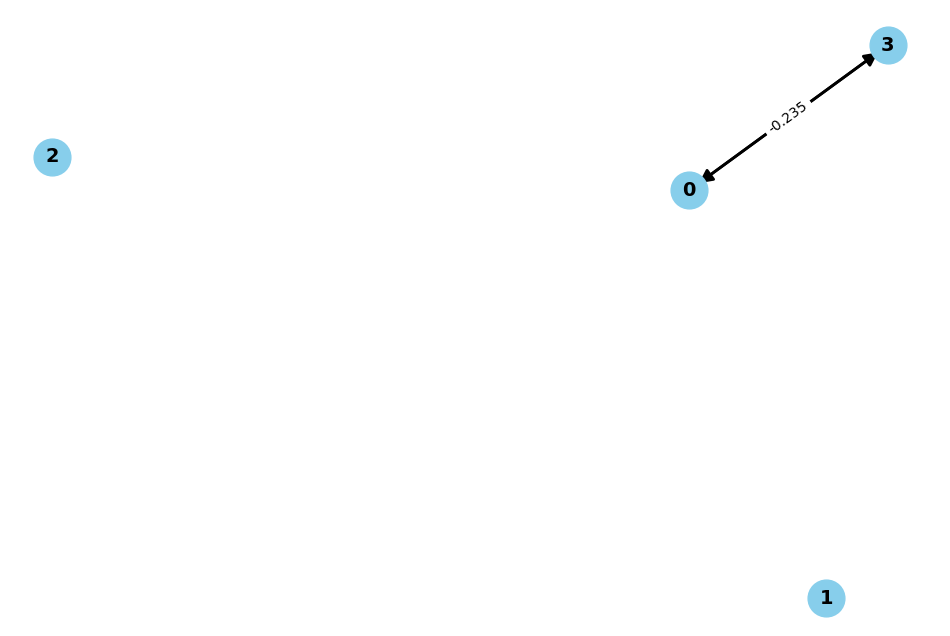

In [701]:
draw_graph_with_edge_weights(Graph_updated)

In [702]:
# Ensure N and time_steps are defined
N = 4  # Number of nodes
time_steps = 5  # Number of time steps

# Initialize the graph and exposures
Graph_updated = create_directional_graph(N)
initial_exposures = [Graph_updated.nodes[i]['exposure'] for i in Graph_updated.nodes]

# Run the simulation for the specified number of time steps
for t in range(time_steps):
    print('timestep', t)
    Graph_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)

    # Print the current state of the graph
    print(len(Graph_updated.edges()), 'edges')
    print('Current exposures:', [Graph_updated.nodes[i]['exposure'] for i in Graph_updated.nodes])

# Print initial exposures
print('initial_exposures:\n', initial_exposures)

# Generate a weighted adjacency matrix
weighted_adj_matrix = nx.adjacency_matrix(Graph_updated, weight='weight').todense()
print('\nAdjacency matrix: \n', weighted_adj_matrix)

timestep 0
0 edges
Current exposures: [-0.06129833559971609, 0.7214691940143303, 0.8481545844498057, -0.10413565359667754]
timestep 1
0 edges
Current exposures: [-0.06129833559971609, 0.7214691940143303, 0.8481545844498057, -0.10413565359667754]
timestep 2
0 edges
Current exposures: [-0.06129833559971609, 0.7214691940143303, 0.8481545844498057, -0.10413565359667754]
timestep 3
0 edges
Current exposures: [-0.06129833559971609, 0.7214691940143303, 0.8481545844498057, -0.10413565359667754]
timestep 4
0 edges
Current exposures: [-0.06129833559971609, 0.7214691940143303, 0.8481545844498057, -0.10413565359667754]
initial_exposures:
 [-0.06129833559971609, 0.7214691940143303, 0.8481545844498057, -0.10413565359667754]

Adjacency matrix: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Number of links at threshold 0.0: 0
Number of links at threshold 0.1: 6
Number of links at threshold 0.2: 12
Number of links at threshold 0.3: 16
Number of links at threshold 0.4: 24
Number of links at threshold 0.5: 30
Number of links at threshold 0.6: 38
Number of links at threshold 0.7: 38
Number of links at threshold 0.8: 38
Number of links at threshold 0.9: 38


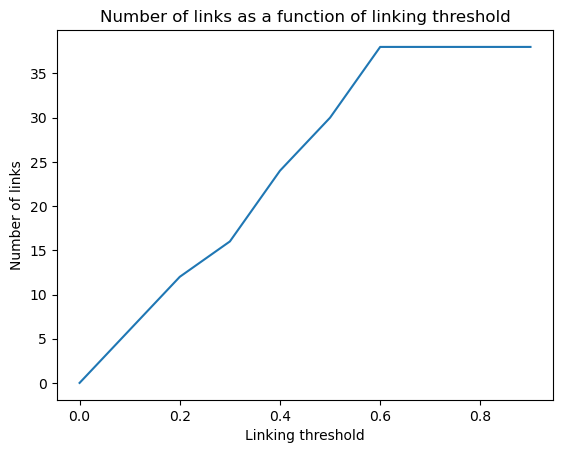

In [703]:
# This cell is purely for testing expected behavior, we expect the number of links to go up as the linking threshold decreases
Graph = create_directional_graph(N_Nodes = 10)
Links_test = []
Link_test_thresholds = []

for i in range(10):
    Graph_updates = form_links_and_update_exposures(G=Graph, linking_threshold=i/10)
    print(f'Number of links at threshold {i/10}: {len(Graph_updates.edges)}')
    Links_test.append(len(Graph_updates.edges))
    Link_test_thresholds.append(i/10)
plt.ylabel('Number of links')
plt.xlabel('Linking threshold')
plt.title('Number of links as a function of linking threshold')
plt.plot(Link_test_thresholds, Links_test)
plt.show()


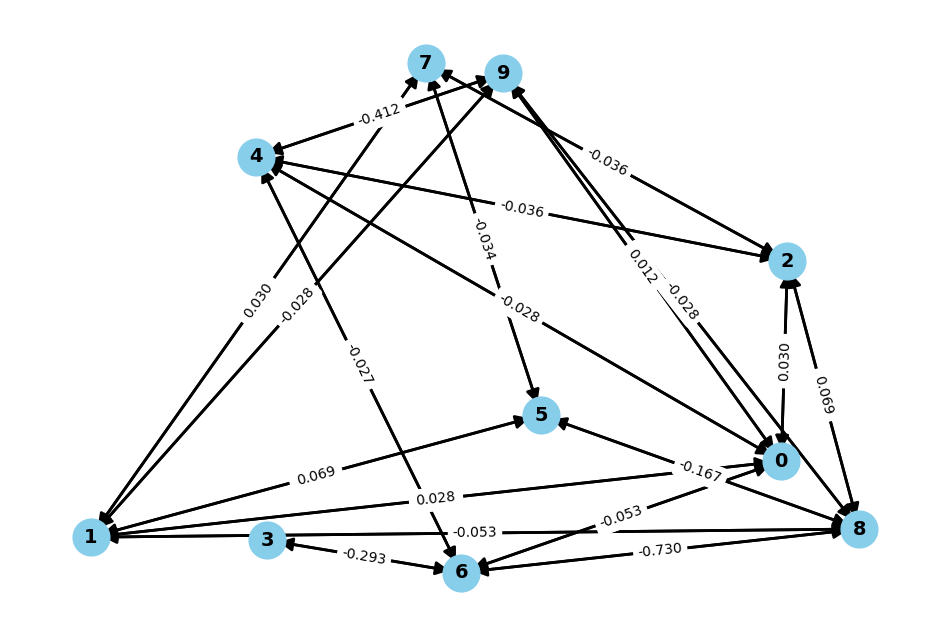

In [704]:
# Amount of links looks to be the same as expected, considering that the links go times 2 because the directional nature of the graph

draw_graph_with_edge_weights(Graph_updates)

# Extending the framework

We need logic to account for when a node dies and what then happens to the exposure of the other nodes, the function below does this:

In [705]:
# Prev, bugged version of the function
def check_bankruptcy_and_update_network(G, threshold_v, delta_price, create_new_node_mode=True):
    bankrupt_nodes = set()
    num_bankruptcies = 0

    # Update exposures based on volatility and identify bankrupt nodes
    for node in G.nodes():
        exposure = G.nodes[node].get('exposure', 0)  # Get exposure from node, defaulting to 0 if not present
        volatility = exposure * delta_price
        if abs(volatility) > threshold_v:
            bankrupt_nodes.add(node)
            num_bankruptcies += 1

    # Process bankrupt nodes
    for node in bankrupt_nodes:
        if node in G:
            # Redistribute exposure to neighbors
            for neighbor in G.neighbors(node):
                if neighbor not in bankrupt_nodes:
                    neighbor_exposure = G.nodes[neighbor].get('exposure', 0)
                    G.nodes[neighbor]['exposure'] = neighbor_exposure + G.edges[node, neighbor]['weight']

            # Remove bankrupt node
            G.remove_node(node)

            if create_new_node_mode:
                new_node_id = max(graph.nodes()) + 1 if graph.nodes() else 0
                graph.add_node(new_node_id, exposure=0, connected_this_timestep=False)

            # # Create new node
            # new_node_id = max(G.nodes()) + 1 if G.nodes() else 0
            # G.add_node(new_node_id) # Initialize new node with default exposure
            # G.nodes[new_node_id]['exposure'] = 0
            # G.nodes[new_node_id]['connected_this_timestep'] = False
            

                
    # if create_new_node_mode:
    #     for _ in range(num_bankruptcies):
    #         new_node_id = max(G.nodes()) + 1 if G.nodes() else 0
    #         G.add_node(new_node_id) # Initialize new node with default exposure
    #         G.nodes[new_node_id]['exposure'] = 0
            # G.nodes[new_node_id]['connected_this_timestep'] = False



    return G, num_bankruptcies

In [706]:
# Modified, seems to past test
def check_bankruptcy_and_update_network(G, threshold_v, delta_price, create_new_node_mode=True):
    bankrupt_nodes = set()
    num_bankruptcies = 0

    # Update exposures based on volatility and identify bankrupt nodes
    for node in G.nodes():
        exposure = G.nodes[node].get('exposure', 0)  # Get exposure from node, defaulting to 0 if not present
        volatility = exposure * delta_price
        if abs(volatility) > threshold_v:
            bankrupt_nodes.add(node)
            num_bankruptcies += 1

    # Process bankrupt nodes
    for node in bankrupt_nodes:
        if node in G:
            # Redistribute exposure to neighbors
            for neighbor in G.neighbors(node):
                if neighbor not in bankrupt_nodes:
                    neighbor_exposure = G.nodes[neighbor].get('exposure', 0)
                    G.nodes[neighbor]['exposure'] = neighbor_exposure + G.edges[neighbor, node]['weight']

            # Remove bankrupt node
            G.remove_node(node)

            if create_new_node_mode:
                # Create new node
                new_node_id = max(G.nodes())+1 if G.nodes() else 0
                G.add_node(new_node_id, exposure=0, connected_this_timestep=False)


    return G, num_bankruptcies

In [707]:

# def check_bankruptcy_and_update_network(G, threshold_v, delta_price, create_new_node_mode=False):
#     bankrupt_nodes = set()
#     num_bankruptcies = 0

#     # Update exposures based on volatility and identify bankrupt nodes
#     for node in G.nodes():
#         exposure = G.nodes[node].get('exposure', 0)  # Get exposure from node, defaulting to 0 if not present
#         volatility = exposure * delta_price
#         if abs(volatility) > threshold_v:
#             bankrupt_nodes.add(node)
#             num_bankruptcies += 1

#     # Process bankrupt nodes
#     for node in bankrupt_nodes:
#         if node in G:
#             # Redistribute exposure to neighbors
#             for neighbor in G.neighbors(node):
#                 if neighbor not in bankrupt_nodes:
#                     neighbor_exposure = G.nodes[neighbor].get('exposure', 0)
#                     G.nodes[neighbor]['exposure'] = neighbor_exposure + G.edges[neighbor, node]['weight']

#             # Remove bankrupt node
#             G.remove_node(node)
            

#             # Handle new node creation
#             if create_new_node_mode:
#                 new_node = max(G.nodes) + 1 if G.nodes else 0
#                 G.add_node(new_node) # Initialize new node with default exposure
#                 G.nodes[new_node]['exposure'] = 0
                
#         if create_new_node_mode:
#             for _ in range(num_bankruptcies):
#                 new_node_id = max(G.nodes()) + 1 if G.nodes() else 0
#                 G.add_node(new_node_id, exposure=0)



#     return G, num_bankruptcies

In [708]:
# Test check_bankruptcy_and_update_network to verify that the exposure of neighbour node has been updated as expected after one node is bankrupt

def test_bankruptcy_and_exposure_update():
    # Create a small test graph
    G = nx.DiGraph()
    G.add_node(0, exposure=20)  # Add a node that will go bankrupt
    G.add_node(1, exposure=4)   # Add a node connected to the bankrupt node
    G.add_node(2, exposure=-2)  # Add another unrelated node
    G.add_edge(1, 0, weight=4)  # Link between bankrupt node and node 1
    G.add_edge(0, 1, weight=-5) # Link in the opposite direction
    # Define test parameters
    threshold_v = 10  # Bankruptcy threshold
    delta_price = 1.5 # Price fluctuation

    # Apply the function
    G, num_bankruptcies = check_bankruptcy_and_update_network(G, threshold_v, delta_price)

    # Verify that the bankrupt node has been removed
    assert 0 not in G

    # Verify that the exposure of node 1 has been updated as expected
    expected_exposure = 4 + 4  # Original exposure + weight of the bankrupt node
    print('expected_exposure:', expected_exposure)
    actual_exposure = G.nodes[1]['exposure']
    print('actual_exposure:', actual_exposure)
    assert actual_exposure == expected_exposure

    # Verify the number of bankruptcies
    assert num_bankruptcies == 1

    # Verify that other nodes are unaffected
    assert G.nodes[2]['exposure'] == -2

    print("All tests passed")

# Run the test function
test_bankruptcy_and_exposure_update()

expected_exposure: 8
actual_exposure: 8
All tests passed


In [709]:
def calculate_first_order_differences(array):
    """
    Calculate the first order differences of a numpy array.

    Parameters:
    array (np.array): The input array.

    Returns:
    np.array: The first order differences of the input array.
    """
    return np.diff(array)


A simulation function putting it all together

In [710]:
def financial_network_simulator(N_agents, num_steps, delta_t, sigma_exposure_node, sigma_intrestrate, threshold_v, linking_threshold):

    
    # Initialize graph with nodes having exposure attributes
    graph = create_directional_graph(N_agents)



    # Initialize 'connected_this_timestep' flag to false for each node
    for i in range(N_agents):
        graph.nodes[i]['connected_this_step'] = False
    


    # Simulate interest rate as Brownian motion
    simulated_prices = brownian_motion(num_steps, delta_t, sigma_intrestrate)

    # Calculate price movement difference for each step
    delta_price_array = calculate_first_order_differences(simulated_prices)

    # Arrays to track metrics over time
    num_bankrupt_agents_total = 0
    num_bankrupt_agents_over_time = np.zeros(num_steps)
    links_over_time = np.zeros(num_steps)
    abs_exposures_over_time_summed = np.zeros(num_steps)
    total_abs_exposure_in_edge_weights = np.zeros(num_steps)
    node_population_over_time = np.zeros(num_steps)

    # Simulate over time
    for step in range(num_steps):
        # Update exposures based on Brownian motion
        for i in graph.nodes():
            graph.nodes[i]['exposure'] += np.random.normal(0, sigma_exposure_node * delta_t)

        # Form links and update exposures based on the current state
        graph = form_links_and_update_exposures(graph, linking_threshold)

        # Check for bankruptcy and update the network
        graph, bankruptcies_this_step = check_bankruptcy_and_update_network(graph, threshold_v, delta_price_array[step-1])


        num_bankrupt_agents_total += bankruptcies_this_step
        
        num_bankrupt_agents_over_time[step] = num_bankrupt_agents_total



        # Update the number of links over time
        links_over_time[step] = graph.number_of_edges()

        # print(np.array(list(nx.get_node_attributes(graph, 'exposure'))))
        # Update the sum of absolute exposures over time
        abs_exposures_over_time_summed[step] = np.sum(np.abs(np.array(list(nx.get_node_attributes(graph, 'exposure')))))

        # Update exposures over time

        print(graph.nodes)
        print(len(graph.nodes))

        # for i in graph.nodes:
        #     print('nodes in graph', len(graph.nodes))
        #     print('index',i)
        #     print('exposures_over_time', abs_exposures_over_time_summed.shape[0])
        #     abs_exposures_over_time_summed[i-1, step] = graph.nodes[i]['exposure']

        abs_exposure_in_edge_weights = sum_absolute_edge_weights(graph)

        total_abs_exposure_in_edge_weights[step] = abs_exposure_in_edge_weights

        node_population_over_time[step] = len(graph.nodes())


        

    return graph, abs_exposures_over_time_summed, num_bankrupt_agents_over_time, simulated_prices, links_over_time, total_abs_exposure_in_edge_weights, node_population_over_time

In [711]:
# Parameters for the simulation
N_agents = 1000
num_steps = 200 # Number of simulation steps
delta_t = 0.01  # Time increment for Brownian motion
sigma_exposure_node = 2  # Standard deviation for Brownian motion
sigma_intrestrate = 40
threshold_v = 2  # Bankruptcy threshold
linking_threshold = 0.01  # Threshold for forming links


# running time 1 pass with these params: 900 seconds

# Running the simulator
graph, exposures_over_time, num_bankrupt_agents_over_time, simulated_prices, links_over_time, total_abs_exposure_in_edge_weights, node_population_over_time = financial_network_simulator(N_agents = N_agents, num_steps = num_steps, sigma_exposure_node = sigma_exposure_node, sigma_intrestrate = sigma_intrestrate, delta_t = delta_t, threshold_v = threshold_v, linking_threshold = linking_threshold)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

# Visual tests of network behavior

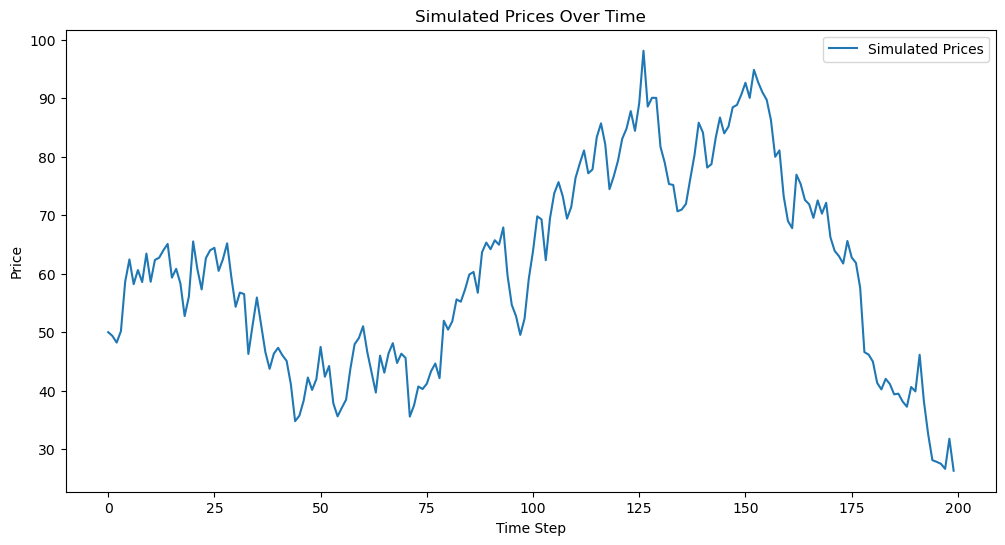

In [712]:
time_steps = np.arange(num_steps)

# Plotting the simulated prices over time
plt.figure(figsize=(12, 6))
plt.plot(time_steps, simulated_prices, label='Simulated Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.title('Simulated Prices Over Time')
plt.legend()
plt.show()


# Old plotting code, possibly remove later

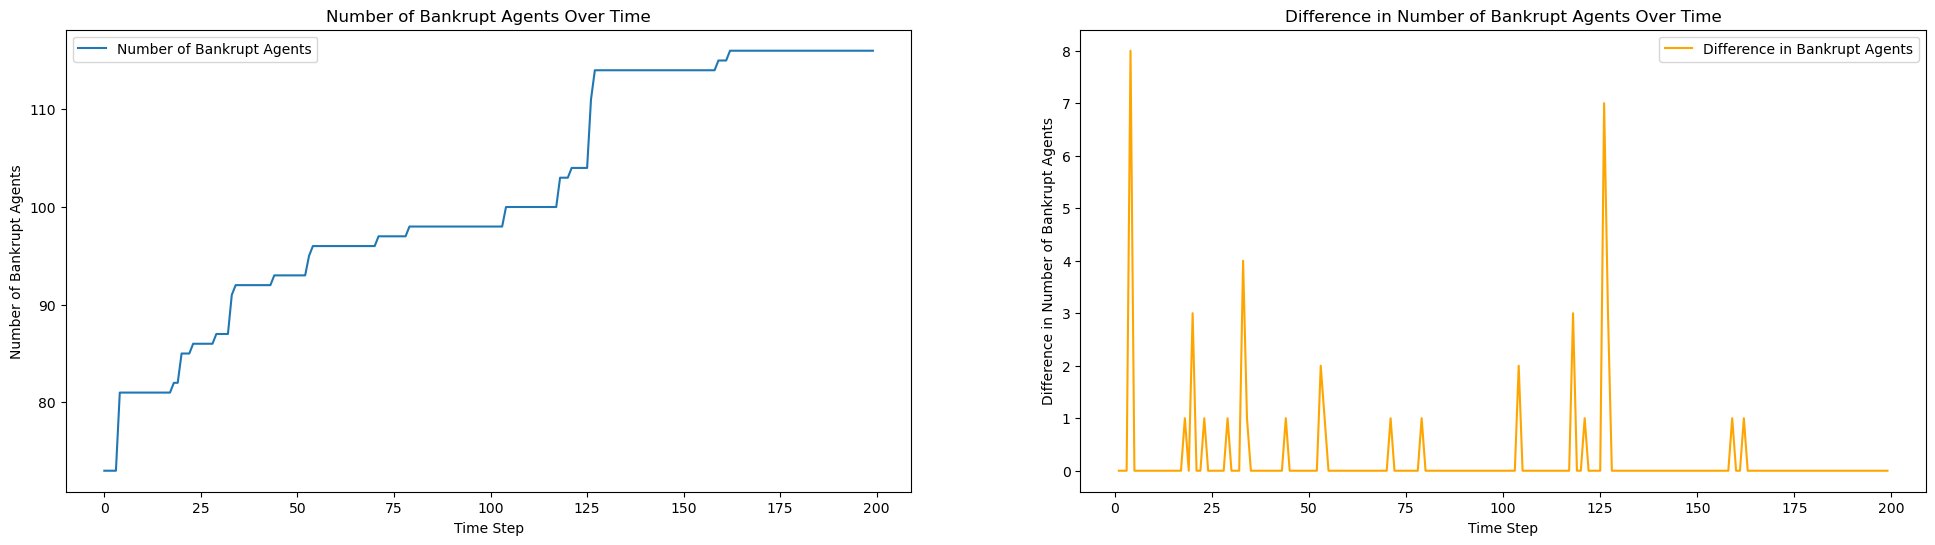

In [713]:
# Calculate the difference in the number of bankrupt agents
diff_bankrupt_agents = np.diff(num_bankrupt_agents_over_time)

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(24, 6))

# First subplot: Original data
plt.subplot(1, 2, 1)
plt.plot(time_steps, num_bankrupt_agents_over_time, label='Number of Bankrupt Agents')
plt.xlabel('Time Step')
plt.ylabel('Number of Bankrupt Agents')
plt.title('Number of Bankrupt Agents Over Time')
plt.legend()

# Second subplot: Difference in data
plt.subplot(1, 2, 2)
plt.plot(time_steps[1:], diff_bankrupt_agents, label='Difference in Bankrupt Agents', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Difference in Number of Bankrupt Agents')
plt.title('Difference in Number of Bankrupt Agents Over Time')
plt.legend()

# Show the plots
plt.show()

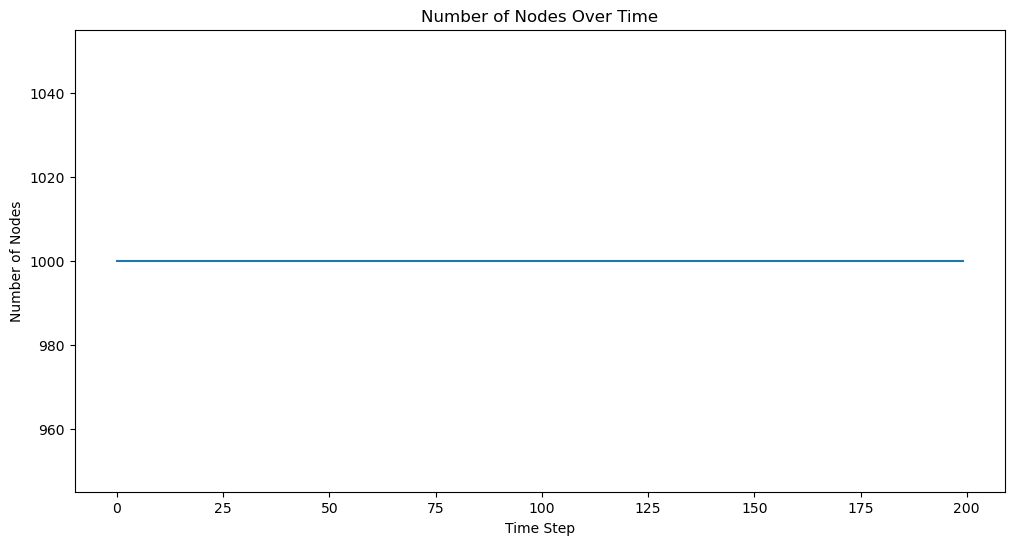

In [714]:
plt.figure(figsize=(12, 6))

plt.plot(node_population_over_time)

plt.xlabel('Time Step')
plt.ylabel('Number of Nodes')
plt.title('Number of Nodes Over Time')
plt.show()

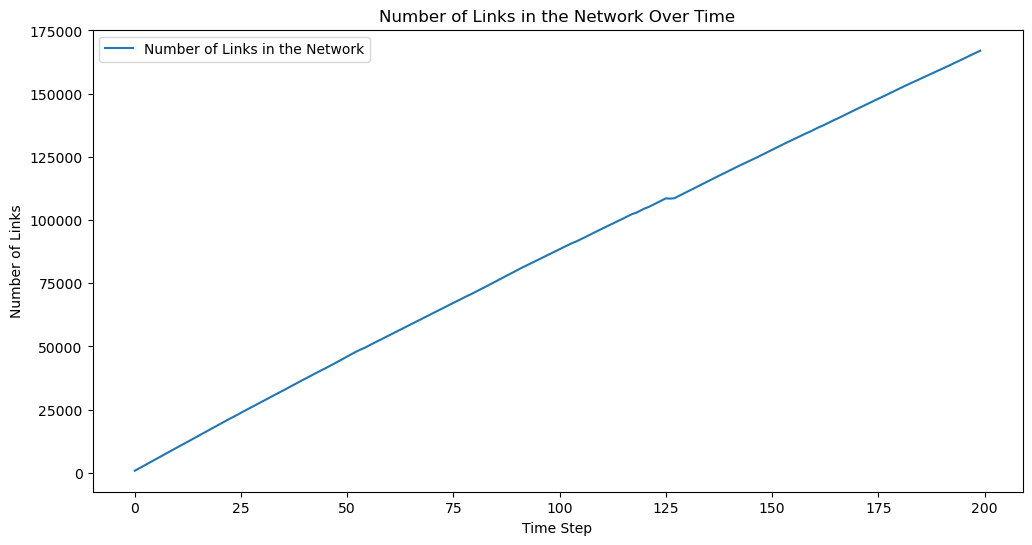

In [715]:

# Plotting the number of links over time
plt.figure(figsize=(12, 6))
plt.plot(time_steps, links_over_time, label='Number of Links in the Network')
plt.xlabel('Time Step')
plt.ylabel('Number of Links')
plt.title('Number of Links in the Network Over Time')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


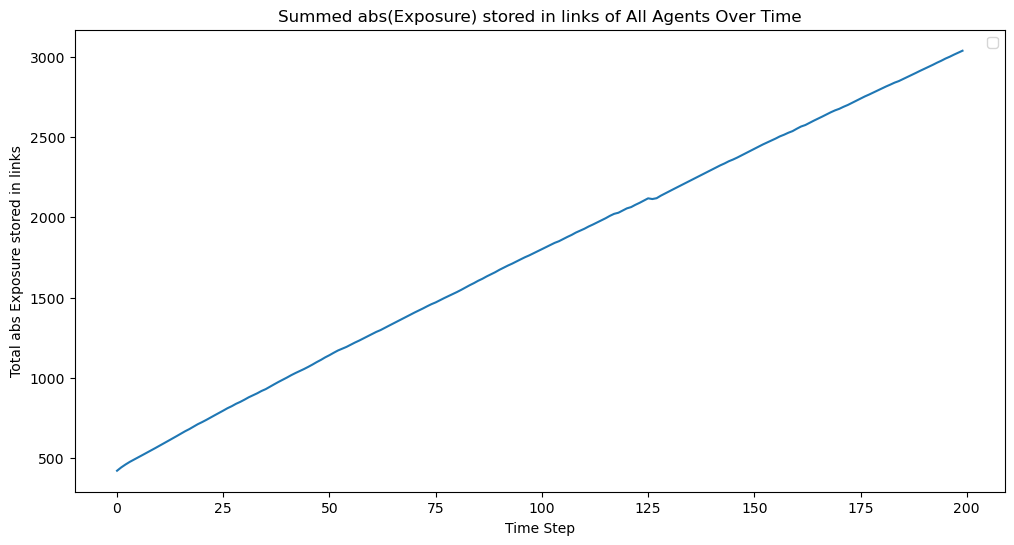

In [716]:
# Plotting the abs exposure stored in links over time
plt.figure(figsize=(12, 6))

plt.plot(total_abs_exposure_in_edge_weights)


plt.xlabel('Time Step')
plt.ylabel('Total abs Exposure stored in links')
plt.title('Summed abs(Exposure) stored in links of All Agents Over Time')
plt.legend()
plt.show()

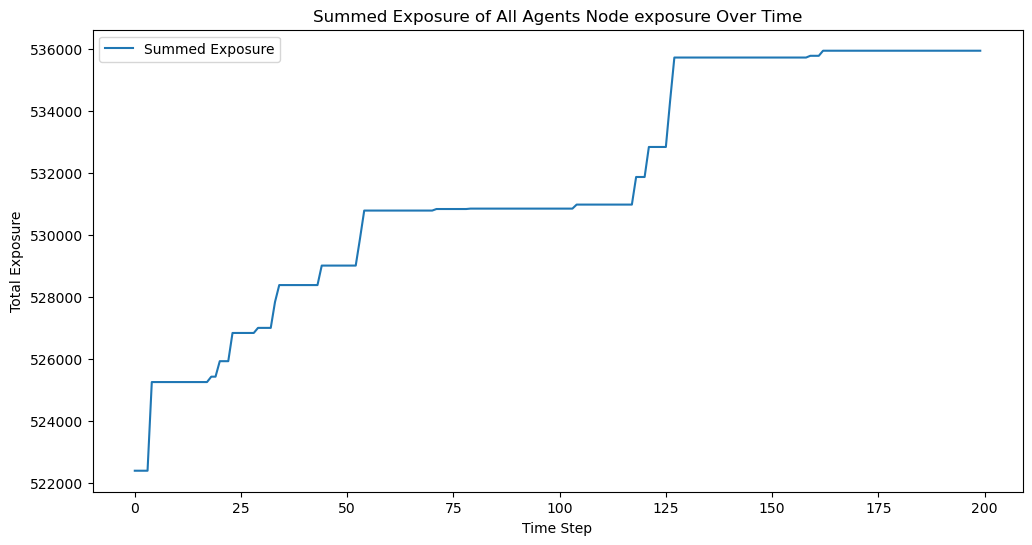

In [717]:



# Plotting the summed exposure over time
plt.figure(figsize=(12, 6))
plt.plot(exposures_over_time, label='Summed Exposure')

plt.xlabel('Time Step')
plt.ylabel('Total Exposure')
plt.title('Summed Exposure of All Agents Node exposure Over Time')
plt.legend()
plt.show()

# New plotting code

In [718]:
def plot_financial_network_results(num_bankrupt_agents_over_time, time_steps, node_population_over_time, links_over_time, total_abs_exposure_in_edge_weights, exposures_over_time, simulated_prices):
    # Calculate the difference in the number of bankrupt agents
    diff_bankrupt_agents = np.diff(num_bankrupt_agents_over_time)

    # Create a large figure to hold all subplots
    plt.figure(figsize=(12, 24))

    # Subplot 1: Number of Bankrupt Agents Over Time
    plt.subplot(4, 2, 1)
    plt.plot(time_steps, num_bankrupt_agents_over_time, label='Number of Bankrupt Agents')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Bankrupt Agents')
    plt.title('Number of Bankrupt Agents Over Time')
    plt.legend()

    # Subplot 2: Difference in Number of Bankrupt Agents
    plt.subplot(4, 2, 2)
    plt.plot(time_steps[1:], diff_bankrupt_agents, label='Difference in Bankrupt Agents', color='orange')
    plt.xlabel('Time Step')
    plt.ylabel('Difference in Number of Bankrupt Agents')
    plt.title('Difference in Number of Bankrupt Agents Over Time')
    plt.legend()


    # Subplot 3: Cumulative Histogram (in reverse order) of Difference in Bankrupt Agents in Log-Log scale
    plt.subplot(4, 2, 3)
    plt.hist(np.abs(diff_bankrupt_agents), bins=50, cumulative=-1, log=True, color='green', label='Cumulative Histogram of Diff in Bankrupt Agents', histtype='step')
    plt.xlabel('Absolute Difference in Number of Bankrupt Agents')
    plt.ylabel('Cumulative Count (Log Scale)')
    plt.title('Cumulative Histogram of Difference in Number of Bankrupt Agents Over Time')
    plt.legend()

    

    # Subplot 4: Simulated Prices Over Time
    plt.subplot(4, 2, 4)
    plt.plot(time_steps, simulated_prices, label='Simulated Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.title('Simulated Prices Over Time')
    plt.legend()

    # Subplot 5: Number of Nodes Over Time
    plt.subplot(4, 2, 5)
    plt.plot(time_steps, node_population_over_time, label='Number of Nodes')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Nodes')
    plt.title('Number of Nodes Over Time')
    plt.legend()

    # Subplot 6: Number of Links in the Network Over Time
    plt.subplot(4, 2, 6)
    plt.plot(time_steps, links_over_time, label='Number of Links in the Network')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Links')
    plt.title('Number of Links in the Network Over Time')
    plt.legend()

    # Subplot 7: Summed abs(Exposure) stored in links of All Agents Over Time
    plt.subplot(4, 2, 7)
    plt.plot(time_steps, total_abs_exposure_in_edge_weights, label='Total abs Exposure in Links')
    plt.xlabel('Time Step')
    plt.ylabel('Total abs Exposure stored in links')
    plt.title('Summed abs(Exposure) stored in links of All Agents Over Time')
    plt.legend()

    # Subplot 8: Summed Exposure of All Agents Node exposure Over Time
    plt.subplot(4, 2, 8)
    plt.plot(time_steps, exposures_over_time, label='Summed Exposure')
    plt.xlabel('Time Step')
    plt.ylabel('Total Exposure')
    plt.title('Summed Exposure of All Agents Node exposure Over Time')
    plt.legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

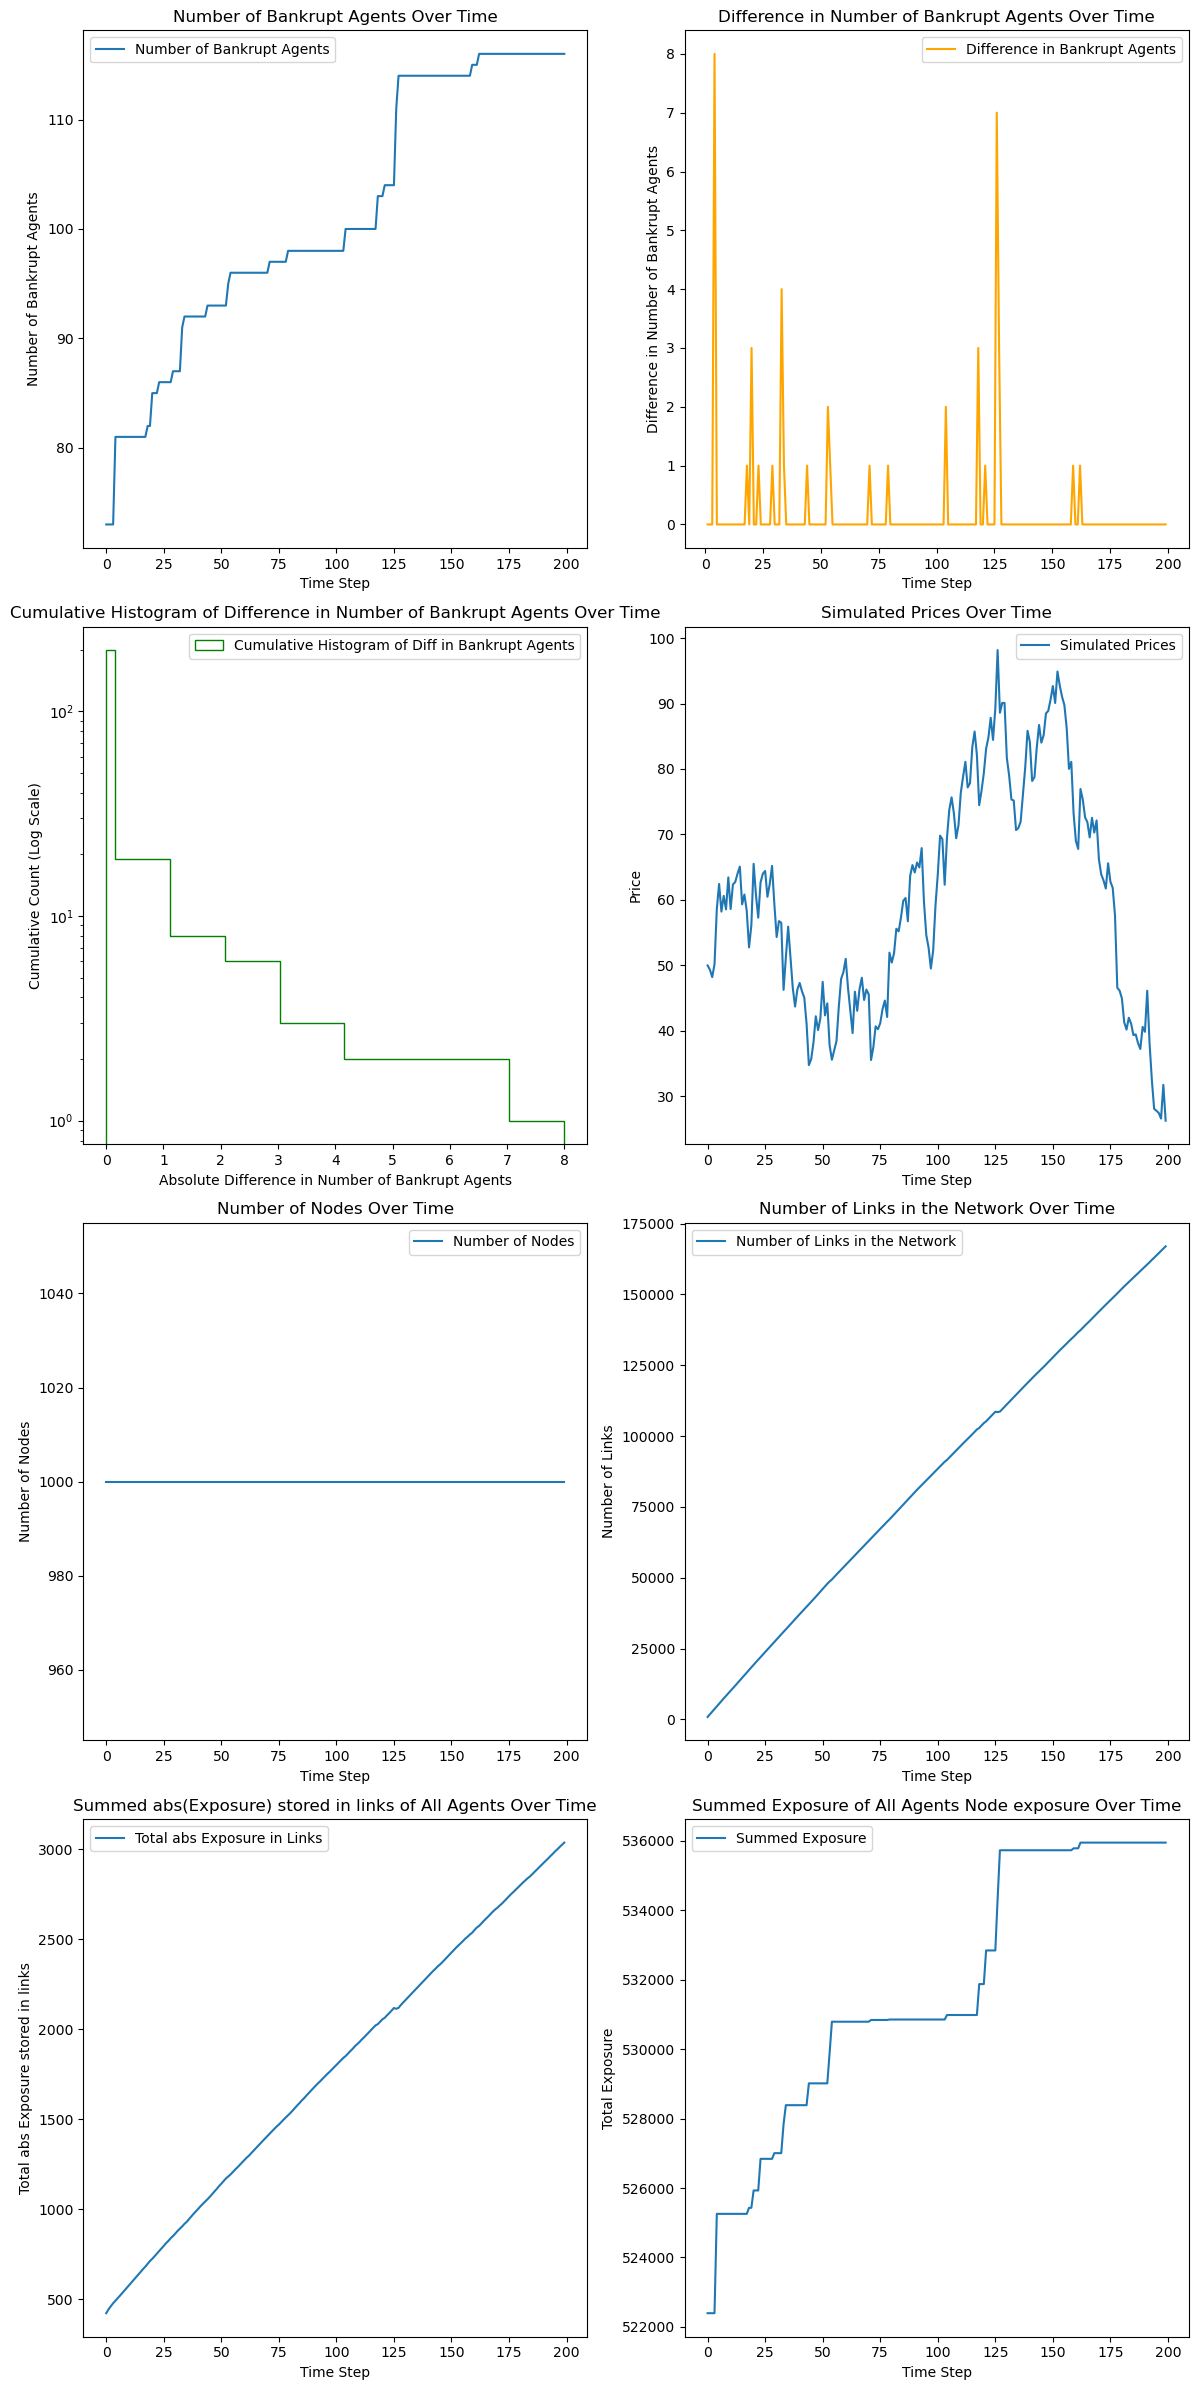

In [719]:
plot_financial_network_results(num_bankrupt_agents_over_time, time_steps, node_population_over_time, links_over_time, total_abs_exposure_in_edge_weights, exposures_over_time, simulated_prices)

# Hypothesis tests


In [726]:
# Fit the data to a power-law distribution

def fit_power_law(data):
    """
    Fit the data to a power-law distribution
    """
    results = powerlaw.Fit(data)
    
    # Plot the PDF and compare it to the power-law.
    plt.figure(figsize=(12, 8))
    results.power_law.plot_pdf(color='b', linestyle='--', label='Power-law fit')
    results.plot_pdf(color='b', label='Empirical Data')
    plt.xlabel('Absolute Difference in Number of Bankrupt Agents')
    plt.ylabel('Probability Density Function (PDF)')
    plt.title('PDF and Power-law Fit of the Data')
    plt.legend()
    plt.show()

    # Calculate the goodness of fit
    R, p = results.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    
    # Output the loglikelihood ratio and p-value
    print(f"Loglikelihood ratio between power law and exponential distribution: {R}")
    print(f"Statistical significance of the fit (p-value): {p}")

    # Conclusion based on the loglikelihood ratio and p-value
    if R > 0 and p < 0.05:
        print("The data follows a power-law distribution better than an exponential distribution.")
    else:
        print("There is not sufficient evidence to conclude that the data follows a power-law distribution better than an exponential distribution.")


**Does the bankruptcy per step follow powerlaw distribution?**

Null Hypothesis (H0): The data follows an exponential distribution as well as or better than a power-law distribution.
Alternative Hypothesis (H1): The data follows a power-law distribution better than an exponential distribution.

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


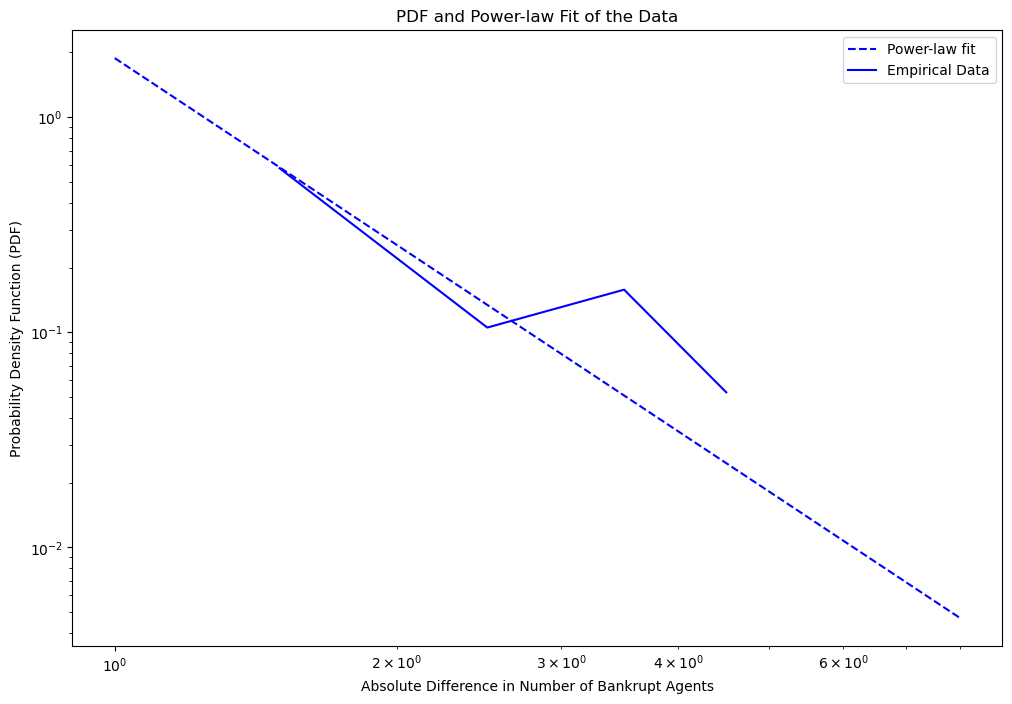

Loglikelihood ratio between power law and exponential distribution: 2.165021404737071
Statistical significance of the fit: 0.030386046109881368
The data follows a power-law distribution better than an exponential distribution.


In [721]:
fit_power_law(np.abs(diff_bankrupt_agents))

# Multiple run simulator

In [722]:
def multi_parameter_financial_network_simulator(runs, N_agents_list, num_steps_list, delta_t_list, sigma_exposure_node_list, sigma_intrestrate_list, threshold_v_list, linking_threshold_list):
    """
    Runs multiple simulations of a financial network simulator for all combinations of given parameter lists. 
    Each simulation is run a specified number of times ('runs') for each combination of parameters.

    Parameters:
    runs (int): The number of times to run the simulation for each combination of parameters.
    N_agents_list (list of int): List of numbers representing the number of agents in the simulation.
    num_steps_list (list of int): List of numbers representing the number of steps in each simulation.
    delta_t_list (list of float): List of delta time values for the simulation.
    sigma_list (list of float): List of sigma values for the simulation.
    threshold_v_list (list of float): List of threshold values for bankruptcy.
    linking_threshold_list (list of float): List of threshold values for linking agents in the network.

    Returns:
    dict: A dictionary where each key is a tuple representing a combination of parameters, and each value 
    is a list of dictionaries. Each dictionary in the list contains the results of a single run of the 
    simulation for that parameter combination. The result dictionary keys are 'graph', 'exposures_over_time',
    'num_bankrupt_agents_over_time', 'simulated_prices', and 'links_over_time'.

    Example:
    To run simulations for combinations of [100, 150] agents and [50, 60] steps, each for 3 runs:
    results = multi_parameter_financial_network_simulator(3, [100, 150], [50, 60], [0.1], [0.05], [1.0], [0.5])
    
    The structure of the returned dictionary for one combination might look like this:
    {
        (100, 50, 0.1, 0.05, 1.0, 0.5): [
            {
                'graph': <networkx.DiGraph object>,
                'exposures_over_time': numpy.ndarray,
                'num_bankrupt_agents_over_time': numpy.ndarray,
                'simulated_prices': numpy.ndarray,
                'links_over_time': numpy.ndarray
            },
            # ... More runs for the same combination ...
        ],
        # ... More parameter combinations ...
    }
    """
    # Dictionary to store results
    results_dict = {}

    # Generate all combinations of parameters
    param_combinations = itertools.product(N_agents_list, num_steps_list, delta_t_list, sigma_exposure_node_list, sigma_intrestrate_list, threshold_v_list, linking_threshold_list)

    for combination in param_combinations:
        N_agents, num_steps, delta_t, sigma_exposure_node, sigma_intrestrate, threshold_v, linking_threshold = combination

        # Initialize the list for this specific combination
        results_dict[combination] = []

        for _ in range(runs):
            # Run the simulation
            graph, exposures_over_time, num_bankrupt_agents_over_time, simulated_prices, links_over_time = financial_network_simulator(N_agents = N_agents, num_steps = num_steps, sigma_exposure_node = sigma_exposure_node, sigma_intrestrate = sigma_intrestrate, delta_t = delta_t, threshold_v = threshold_v, linking_threshold = linking_threshold)

            # Store results for this run
            run_result = {
                'graph': graph,
                'exposures_over_time': exposures_over_time,
                'num_bankrupt_agents_over_time': num_bankrupt_agents_over_time,
                'simulated_prices': simulated_prices,
                'links_over_time': links_over_time
            }
            results_dict[combination].append(run_result)

    return results_dict

In [723]:
# data_of_multirun = multi_parameter_financial_network_simulator(runs=10, N_agents_list=[50,100,500,1000], num_steps_list=[200], delta_t_list=[0.01], sigma_exposure_node_list = [0,1,2,3,4,5],  sigma_intrestrate_list = [0,2,4,6,8,10], threshold_v_list= [10,8,6,4,2,1,0.5,0.2,0.1], linking_threshold_list = [0.5,0.4,0.3,0.2,0.1])

# Exploratory Data Analysis Functions

In [724]:
def analyze_network(G):
    # Initialize DataFrame
    stats_df = pd.DataFrame(index=G.nodes())

    # Centralities
    stats_df['Betweenness Centrality'] = pd.Series(nx.betweenness_centrality(G))
    stats_df['Closeness Centrality'] = pd.Series(nx.closeness_centrality(G))
    stats_df['Eigenvector Centrality'] = pd.Series(nx.eigenvector_centrality(G, max_iter=500))

    # Node Degree (In and Out for Directed Graph)
    if G.is_directed():
        stats_df['In-Degree'] = pd.Series(dict(G.in_degree()))
        stats_df['Out-Degree'] = pd.Series(dict(G.out_degree()))
    else:
        stats_df['Degree'] = pd.Series(dict(G.degree()))

    # Diameter and Average Shortest Path Length
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        avg_shortest_path = nx.average_shortest_path_length(G)
        stats_df['Diameter'] = diameter
        stats_df['Average Shortest Path Length'] = avg_shortest_path
    else:
        print("The graph is not connected. Diameter and Average Shortest Path Length cannot be computed.")

    # Plot Degree Distribution
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 1, 1))
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    return stats_df

In [725]:
# Used to calculate the volatility (standard deviation) of a time series

def calculate_std_diff(timeseries):
    """
    Calculate the standard deviation of the first-order differences of a time series.

    Parameters:
    timeseries (np.array): A time series data in the form of a NumPy array.

    Returns:
    float: The standard deviation of the first-order differences of the time series.
    """
    return np.std(np.diff(timeseries))

# What we add in comparison to the paper Drupsteen 2019:

- we add a preferential attachment linking mechanism, meaning agens prefer to link with other agents such that the summed exposure is as close to 0 as possible.
- we add exposure to an external asset (intrest rate) instead of just merely looking at exposure. This allows moddeling the effect of price swings on the default cascade probability

# Experiments


In this part of the notebook, we conduct experiments to identify properties of the network. We want to conduct the following experiments

1. Look at the distribution of avalanche sizes vs. system size, to see if it is powerlaw
2. Look at the probability of avalanche vs. system size
3. Look at the probability of avalanche as a function of volatility of the price time series
4. Look at stress in the system vs. probability of avalanche vs. volatility of the asset
5. Look at multiple thresholding functions to compare
